###  Episodic one-step actor-critic with eligibility traces (programming)

Implement the one-step actor-critic algorithm with eligibility traces for
episodic tasks and apply it to one of the environments that you have
implemented previously. How does the algorithm compare to other
ones?

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from random import choice, random, randint
from tqdm import tqdm_notebook as tqdm

In [3]:
class Grid:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.start = w-1
        self.goal = 0
        
        self.terminal = [self.goal]
        self.states = [s for s in range(0, h*w)]
        self.cliff = []
#         self.states = [s for s in range(w, h*w)] + [self.start, self.goal]
#         self.cliff = [s for s in range(self.goal+1, self.start)]
        
        self.num_states = h*w
        self.num_actions = len(self.actions)
        
        #### state numbering ####
        # 0  1  2  3  4  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        # 18 19 20 21 22 23
        
        # 0 is the final state
        # 5 is the starting state
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
        
    def step(self, s, a):
        assert s in (self.states + [self.start, self.goal]), f'{s=} not valid.'
        
        if s in self.terminal:
            return s, 0
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if sprime in self.cliff:
            return self.start, -100
        elif (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1

# Returns ground truth value function for the optimal policy
def get_GT(grid):
    w = grid.w
    h = grid.h
    
    v = np.zeros((h, w))
    v_states = np.zeros(h*w)
    
    for x in range(w):
        for y in range(h):
            v[y, x] = x + y
            v_states[y*w + x] = x + y
    for x in range(w):
        v[0, x] = np.nan
        v_states[x] = np.nan
            
    v[0, 0] = 0
    v_states[0] = 0
    v[0, w-1] = w+1
    v_states[w-1] = w+1
            
    return -v, -v_states

In [4]:
# The features return the a'th unit vector times the distance relevant to the action
# (for example for 'up' that would be the difference in the y direction, while for down it would the negative of that)
def sa_features(s, a, grid):
    ty, tx = grid.state_coordinates(grid.terminal[0])
    sy, sx = grid.state_coordinates(s)
    
    unit = np.eye(len(grid.actions))[a]
    
    if a == 0: # up
        return unit*(sy - ty)
    elif a == 1: # down
        return unit*(ty - sy)
    elif a == 2: # right
        return unit*(tx - sx)
    elif a == 3: # left
        return unit*(sx - tx)
    else:
        raise NotImplementedError

# optimal features, feels almost like cheating, alternatively the ones below also work
def s_features(s, grid):
    ty, tx = grid.state_coordinates(grid.terminal[0])
    sy, sx = grid.state_coordinates(s)
    
    # The feature is the manhatten distance between s and the terminal state
    return np.array([(sy-ty) + (sx-tx)])
    
# def s_features(s, grid):
#     t_coords = grid.state_coordinates(grid.terminal[0])
#     s_coords = grid.state_coordinates(s)
    
#     dist = np.sqrt(((np.array(t_coords) - np.array(s_coords))**2).sum())
#     x = s_coords + (dist,)
    
#     return np.array(x)

# Linear preferences
def policy(s, theta, env):
    unnormalized = np.array([np.exp(theta @ sa_features(s, a, env)) for a in env.actions])
    return unnormalized/unnormalized.sum()

# Linear value fct
def value(s, w, env):
    return w @ s_features(s, env)

In [7]:
def one_step_actor_critic_with_eligibility_traces(grid, alpha_theta=0.01, alpha_w=0.01, lambda_theta=0.9, lambda_w=0.9, episodes=1000, gamma=1.0, max_steps=100):
    theta = np.zeros(len(sa_features(0,0,grid)))
    w = np.zeros(len(s_features(0,grid)))
    I = 1.0
    rewards = []
    episode_steps = []
                 
    for ep in tqdm(range(episodes)):
        S = choice(grid.states)
        z_theta = np.zeros(theta.shape)
        z_w = np.zeros(w.shape)
        reward = 0
        
        for step in range(max_steps):
            policy_probs = policy(S, theta, grid)
            A = np.random.choice(grid.actions, p=policy_probs)
            S_prime, R = grid.step(S, A)
            
#             print(f'   {step=}, {S=}, {A=}, {S_prime=}')
            delta = R + gamma*value(S_prime, w, grid) - value(S, w, grid)
            derivative_log_policy = sa_features(S, A, grid) - np.sum([policy_probs[a]*sa_features(S, a, grid) for a in grid.actions])
            
            z_w = gamma*lambda_w*z_w + s_features(S, grid)
            z_theta = gamma*lambda_theta*z_theta + I*derivative_log_policy
            
            w = w + alpha_w*delta*z_w
            theta = theta + alpha_theta*delta*z_theta

            I = gamma*I
            S = S_prime
            
            reward += R
            if S_prime == grid.goal:
                break
                
#         print(f'{ep=}, {reward=}, {step=}')
        rewards.append(reward)
        episode_steps.append(step)
        
    return theta, w, rewards, episode_steps   

In [8]:
h, w = 4, 6

g = Grid(h, w)

In [52]:
theta_out, w_out, rewards_list, step_list = one_step_actor_critic_with_eligibility_traces(g, gamma=1.0, alpha_w=0.01, alpha_theta=0.01, episodes=4000)

/tmp/ipykernel_171/959206151.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(episodes)):


  0%|          | 0/4000 [00:00<?, ?it/s]

In [53]:
theta_out

array([  9.91875445,  -5.68696047,  -4.84112309, -15.8528643 ])

In [54]:
w_out

array([-1.00000001])

In [68]:
print('reward stats (first 100 episodes):')
print(f'mean: {np.mean(rewards_list[:1000])}, std: {np.std(rewards_list[:1000])}')

reward stats (first 100 episodes):
mean: -5.062, std: 9.31859195372348


In [56]:
print('reward stats (last 1000 episodes):')
print(f'mean: {np.mean(rewards_list[1000:])}, std: {np.std(rewards_list[1000:])}')

reward stats (last 1000 episodes):
mean: -4.138, std: 2.0847756074295702


In [69]:
print('step stats (first 100 episodes):')
print(f'mean: {np.mean(step_list[:1000])}, std: {np.std(step_list[:1000])}')

step stats (first 100 episodes):
mean: 4.109, std: 9.295435385176964


In [58]:
print('step stats (last 1000 episodes):')
print(f'mean: {np.mean(step_list[1000:])}, std: {np.std(step_list[1000:])}')

step stats (last 1000 episodes):
mean: 3.1723333333333334, std: 2.023685060038301


The average reward per epoch


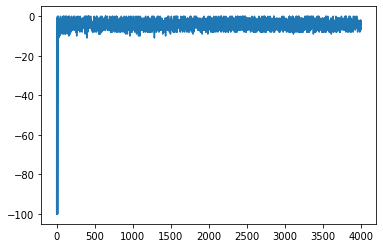

In [59]:
print('The average reward per epoch')
plt.plot(rewards_list)

The average number of steps per epoch


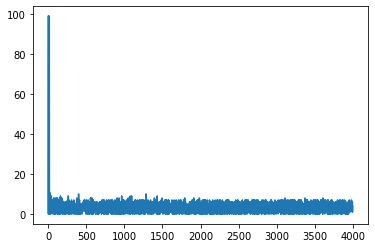

In [60]:
print('The average number of steps per epoch')
plt.plot(step_list)

In [61]:
V = np.zeros([h, w])

for s in g.states:
    sy, sx = g.state_coordinates(s)
    V[sy, sx] = value(s, w_out, g)

Value function
[[ 0. -1. -2. -3. -4. -5.]
 [-1. -2. -3. -4. -5. -6.]
 [-2. -3. -4. -5. -6. -7.]
 [-3. -4. -5. -6. -7. -8.]]


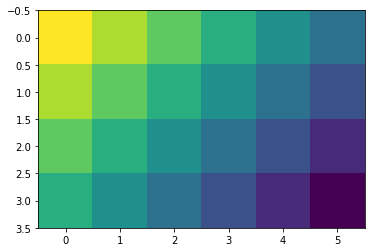

In [62]:
print('Value function')
print(V.round(decimals=2))
plt.imshow(V)

In [63]:
π = np.zeros([h, w, len(g.actions)])

for s in g.states:
    sy, sx = g.state_coordinates(s)
    π[sy, sx] = policy(s, theta_out, g)

UP
[[0.25 0.01 0.   0.   0.   0.  ]
 [0.99 0.98 0.55 0.01 0.   0.  ]
 [1.   1.   1.   0.99 0.62 0.01]
 [1.   1.   1.   1.   1.   1.  ]]


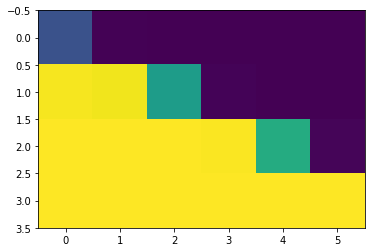

In [64]:
print('UP')
print(π[:,:,0].round(decimals=2))
plt.imshow(π[:,:,0])

DOWN
[[0.25 0.01 0.   0.   0.   0.  ]
 [0.01 0.01 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


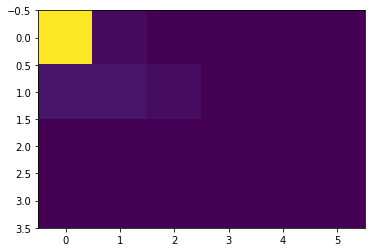

In [65]:
print('DOWN')
print(π[:,:,1].round(decimals=2))
plt.imshow(π[:,:,1])

LEFT
[[0.25 0.98 1.   1.   1.   1.  ]
 [0.   0.01 0.44 0.99 1.   1.  ]
 [0.   0.   0.   0.   0.38 0.99]
 [0.   0.   0.   0.   0.   0.  ]]


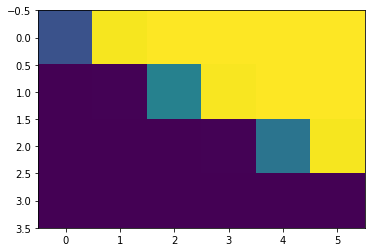

In [66]:
print('LEFT')
print(π[:,:,2].round(decimals=2))
plt.imshow(π[:,:,2])

RIGHT
[[0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


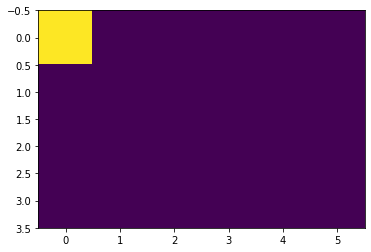

In [67]:
print('RIGHT')
print(π[:,:,3].round(decimals=2))
plt.imshow(π[:,:,3])

How does it compare to other ones? The performance of these methods depends to a very large degree on the qualities of the features. The features must be chosen such that learning the objective is possible. For such a simple problem it's is relatively easy to guess appropriate features, however for more complicated problems handcrafted features are hard to get work which motivates the usage of neural networks.